In [8]:
import triton
import keystone
import graphviz

In [9]:
ks = keystone.Ks(keystone.KS_ARCH_X86, keystone.KS_MODE_32)
def asmDecode(CODE: bytes) -> bytes:
    try:
        encoding, count = ks.asm(CODE)
        if (count <= 0):
            raise keystone.KsError
        return bytes(encoding)
    except keystone.KsError as e:
        print("ERROR: %s" %e)
        return b""

In [10]:
# 设置参数
a = 0x1234
b = 0x1235
f1 = 0x11111111
f2 = 0x22222222

In [11]:
codeStr = [
    f"mov esi, {hex(a)}", # 符号化为 Sym_A
    f"mov eax, esi",
    f"mov esi, {hex(b)}", # 符号化为 Sym_B
    f"sub eax, esi",

    f"pushfd",
    f"pop eax",

    f"and eax,0x40", # 提取zf位
    f"shr eax,6", # 此时eax是1或0

    f"sub esp,8",
    f"mov dword ptr ss:[esp+4], {hex(f1)}",
    f"mov dword ptr ss:[esp], {hex(f2)}",
    f"mov eax, dword ptr ss:[esp+eax*4]",
    f"add esp, 8",
    
    f"call eax"
]

code: list[bytes] = []

for idx, l in enumerate(codeStr):
    code.append(asmDecode(l))
    print(f"{idx}\t{l}")

0	mov esi, 0x1234
1	mov eax, esi
2	mov esi, 0x1235
3	sub eax, esi
4	pushfd
5	pop eax
6	and eax,0x40
7	shr eax,6
8	sub esp,8
9	mov dword ptr ss:[esp+4], 0x11111111
10	mov dword ptr ss:[esp], 0x22222222
11	mov eax, dword ptr ss:[esp+eax*4]
12	add esp, 8
13	call eax


In [12]:
ctx = triton.TritonContext()
ctx.setArchitecture(triton.ARCH.X86)
ctx.setAstRepresentationMode(triton.AST_REPRESENTATION.PYTHON)
ctx.setMode(triton.MODE.ALIGNED_MEMORY, True)
ctx.setMode(triton.MODE.AST_OPTIMIZATIONS, True)
ctx.setMode(triton.MODE.CONSTANT_FOLDING, True)
ctx.setMode(triton.MODE.ONLY_ON_SYMBOLIZED, True)
ctx.setMode(triton.MODE.MEMORY_ARRAY, True)
ctx.setMode(triton.MODE.SYMBOLIZE_LOAD, True)
ctx.setMode(triton.MODE.SYMBOLIZE_STORE, True)
ctx.setMode(triton.MODE.SYMBOLIZE_INDEX_ROTATION, True)
astctx = ctx.getAstContext()

def newLiftDot(expr_node) -> str:
    temp_ctx = triton.TritonContext()
    temp_ctx.setArchitecture(ctx.getArchitecture())
    return temp_ctx.liftToDot(expr_node)

In [13]:
for i, bys in enumerate(code):
    ttins = triton.Instruction()
    ttins.setOpcode(bys)

    ctx.processing(ttins)
    if (i == 0):
        ctx.symbolizeRegister(ctx.registers.esi, "Sym_A")
    if (i == 2):
        ctx.symbolizeRegister(ctx.registers.esi, "Sym_B")
    if (i == 11):
        memast = astctx.unroll(ctx.getRegisterAst(ctx.registers.eax))
        print(f"{memast}")

((((select(store(store(store(store(store(store(store(store(store(store(store(store(Memory, 0xffffffff, ((((((((((((((((((((((((0x0) << 1 | 0x0) << 1 | 0x0) << 1 | 0x0) << 1 | 0x0) << 1 | 0x0) << 1 | 0x0) << 1 | 0x0) << 1 | 0x0) << 1 | 0x0) << 1 | ((((Sym_A ^ Sym_B) & (Sym_A ^ ((Sym_A - Sym_B) & 0xffffffff))) >> 31) & 0x1)) << 1 | 0x0) << 1 | 0x0) << 1 | 0x0) << 1 | ((((Sym_A - Sym_B) & 0xffffffff) >> 31) & 0x1)) << 1 | (0x1 if (((Sym_A - Sym_B) & 0xffffffff) == 0x0) else 0x0)) << 1 | 0x0) << 1 | (0x1 if (0x10 == (0x10 & (((Sym_A - Sym_B) & 0xffffffff) ^ (Sym_A ^ Sym_B)))) else 0x0)) << 1 | 0x0) << 1 | ((((((((0x1 ^ (((Sym_A - Sym_B) & 0xffffffff) & 0x1)) ^ ((((Sym_A - Sym_B) & 0xffffffff) >> 1) & 0x1)) ^ ((((Sym_A - Sym_B) & 0xffffffff) >> 2) & 0x1)) ^ ((((Sym_A - Sym_B) & 0xffffffff) >> 3) & 0x1)) ^ ((((Sym_A - Sym_B) & 0xffffffff) >> 4) & 0x1)) ^ ((((Sym_A - Sym_B) & 0xffffffff) >> 5) & 0x1)) ^ ((((Sym_A - Sym_B) & 0xffffffff) >> 6) & 0x1)) ^ ((((Sym_A - Sym_B) & 0xffffffff) >> 7) & 

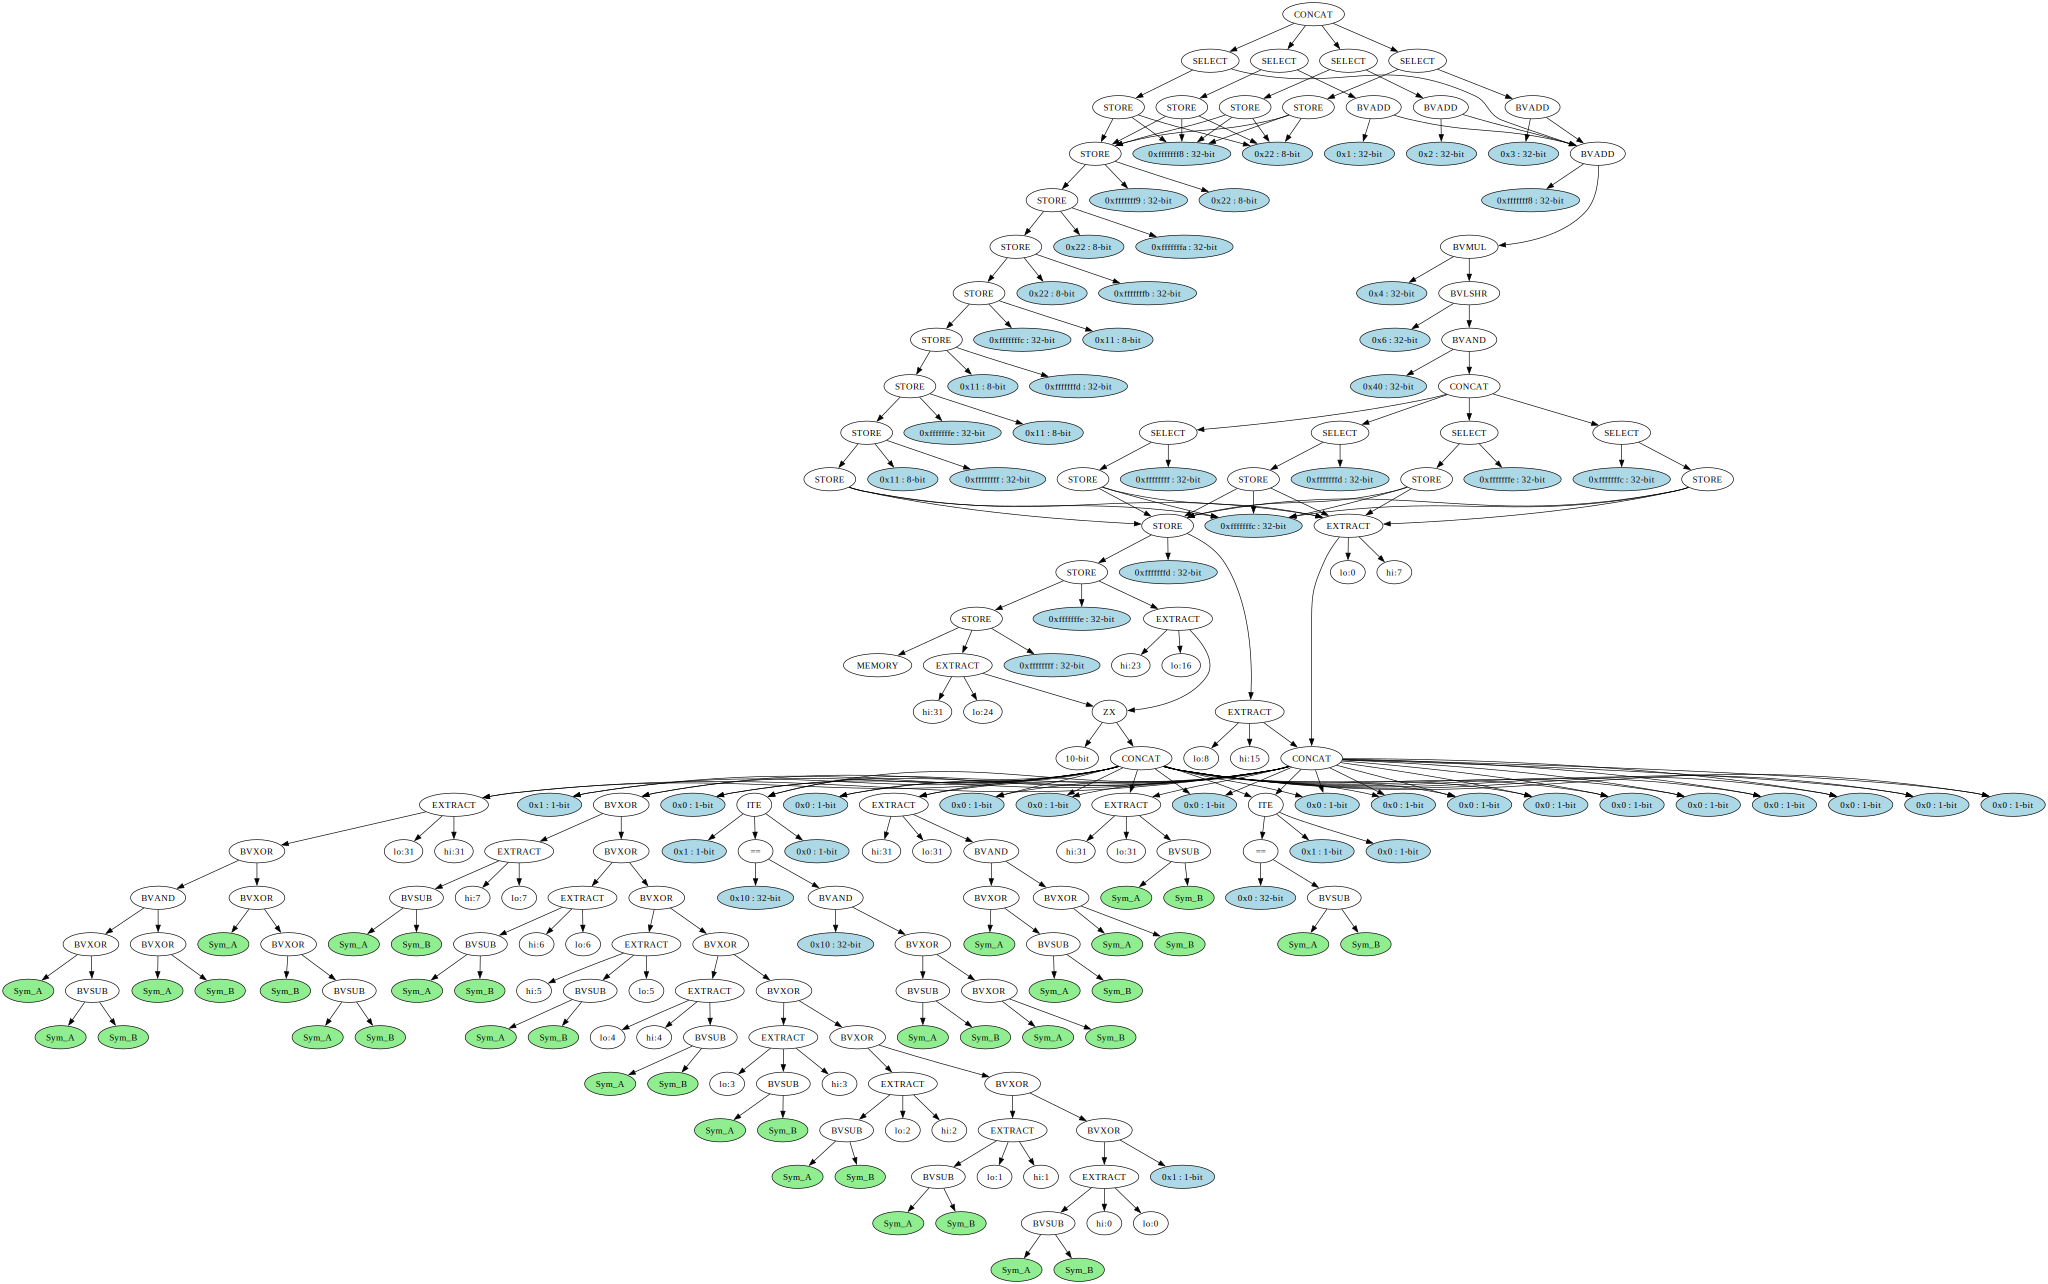

In [14]:
graphviz.Source(newLiftDot(memast))